# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [1]:
# libraries
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm
#from tqdm import tqdm
import EndovisDataloader
import BBAModule
import EncoderModule
import TrainingUtils
import BAAnet
import DecoderModule


### Process Endovis 2018 Dataset

In [2]:
# set seed for reprodicibility
def set_seed(seed):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch random seed for CPU
    torch.cuda.manual_seed(seed)  # PyTorch random seed for GPU
    torch.cuda.manual_seed_all(seed)  # PyTorch random seed for all GPUs 
    # Ensure deterministic behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# get dataloaders and display test images
seed = 42
batch_size = 8
reduce_factor = 4 # how much to reduce image size by before training
num_workers = 0 # 0 for notebooks
train_dataloader, val_dataloader, test_dataloader = EndovisDataloader.getDataloaders(batch_size, reduce_factor, num_workers,seed)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
images,labels = next(iter(train_dataloader))

# n = 2
# cmap = plt.get_cmap('Paired',12)
# cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
# cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
#                "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

# fig, axes = plt.subplots(n, 2, figsize=(20, 20))
# for i in range(n):  # Flatten the 2D array of axes
#     axes[i,0].imshow(images[i].permute(1, 2, 0))  
#     #axes[i,1].imshow(labels[i].permute(1, 2, 0))
#     label_img = EndovisDataloader.convert_masks_to_gray(labels[i])
#     im = axes[i,1].imshow(label_img, cmap = cmap, vmin = 0, vmax = 11) # Display the image in grayscale
#     # colorbar settings
#     cbar = fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
#     cbar.set_label("Segmentation Labels", fontsize=10)
#     cbar.set_ticks(cbar_ticks)
#     cbar.set_ticklabels(cbar_labels)

# plt.tight_layout()
# plt.show()

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (320, 256)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997


In [ ]:
# DEBUGGING
encoder = EncoderModule.MobileNetV2Encoder(pretrained=True)
input = images[0:1]
label = labels[0:1]
print("x0:",input.shape)

x1,x2,x3,x4 = encoder(input)

print("x1:", x1.shape)
print("x2:", x2.shape)
print("x3:", x3.shape)
print("x4:", x4.shape)

channels = [24,32,64,160]
BBA = BBAModule.BBAModule(channels)
y1,y2,y3,y4 = BBA(x1,x2,x3,x4)

print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

model = DecoderModule.DecoderModule([24,32,64,64])
img = model(y1,y2,y3,y4)
print()
print("Decoder:", img.shape)


model_BBA = BAAnet.BAANet_BBA_Only()
out = model_BBA(input)
print()
print("BAA_Only:", out.shape)

model_full = BAAnet.BAANet()
out = model_full(input)
print()
print("BAAnet Full:", out.shape)


model_BAF = BAAnet.BAANet_BAF_Only()
out = model_full(input)
print()
print("BAF Only:", out.shape)

## Create Model and Hyperparameters


In [3]:
# model and hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 50
lr = 1e-4

#set_seed(seed) # set random seed
#model = BAAnet.BAANet_BBA_Only().to(device)
#model = BAAnet.BAANet().to(device)
model = BAAnet.BAANet_BAF_Only().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
criterion = TrainingUtils.DICELoss # loss function
#criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # learning rate scheduler

cuda:0


c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# train model. Output is [epoch, training_loss, mdice, miou, mdice_robot, miou_robot]
training_outputs = []
for i in range(epochs):
    training_output = TrainingUtils.train(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler, i, device)
    training_outputs.append(training_output)

0it [00:00, ?it/s]c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
205it [04:43,  1.38s/it]
75it [10:12,  8.17s/it]


Epoch 0: Training Loss = 0.9479500932402954, mDICE: 0.5760288540875392, mIoU: 0.5538859060980366 mDICE Robot: 0.4592047626675463, mIoU Robot: 0.32240484430214006


205it [03:44,  1.09s/it]


Epoch 1: Training Loss = 0.9370998385508663, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:46,  1.11s/it]


Epoch 2: Training Loss = 0.9334799538579499, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:53,  1.14s/it]


Epoch 3: Training Loss = 0.9302770999134201, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:58,  1.16s/it]


Epoch 4: Training Loss = 0.9284149672940979, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:58,  1.16s/it]
75it [10:00,  8.01s/it]


Epoch 5: Training Loss = 0.9271814007722251, mDICE: 0.6170118173327291, mIoU: 0.58562127693945 mDICE Robot: 0.5680800078001701, mIoU Robot: 0.4281550420506679


205it [03:48,  1.11s/it]


Epoch 6: Training Loss = 0.926138294602631, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:48,  1.12s/it]


Epoch 7: Training Loss = 0.9251281849722081, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:47,  1.11s/it]


Epoch 8: Training Loss = 0.9244844134536008, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:54,  1.14s/it]


Epoch 9: Training Loss = 0.9239879655071226, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:48,  1.11s/it]
75it [10:05,  8.07s/it]


Epoch 10: Training Loss = 0.9236586068759356, mDICE: 0.5819617931476808, mIoU: 0.55810522051048 mDICE Robot: 0.24714494168949086, mIoU Robot: 0.15454964978263544


205it [03:50,  1.13s/it]


Epoch 11: Training Loss = 0.9233686370072982, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:56,  1.15s/it]


Epoch 12: Training Loss = 0.9231666126433119, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:02,  1.18s/it]


Epoch 13: Training Loss = 0.9229054888554378, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:53,  1.14s/it]


Epoch 14: Training Loss = 0.9226975154849375, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:48,  1.12s/it]
75it [09:52,  7.90s/it]


Epoch 15: Training Loss = 0.9225442473081533, mDICE: 0.5636090430004559, mIoU: 0.5403592265466922 mDICE Robot: 0.24419627723965417, mIoU Robot: 0.15582505039253178


205it [03:43,  1.09s/it]


Epoch 16: Training Loss = 0.922387174790071, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:45,  1.10s/it]


Epoch 17: Training Loss = 0.9222013144512272, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:50,  1.12s/it]


Epoch 18: Training Loss = 0.9220115012073882, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:51,  1.13s/it]


Epoch 19: Training Loss = 0.9216151713781342, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:51,  1.13s/it]
75it [09:48,  7.85s/it]


Epoch 20: Training Loss = 0.9208209567222568, mDICE: 0.5294437932857272, mIoU: 0.5074764540385521 mDICE Robot: 0.2361263083565707, mIoU Robot: 0.14962005984405816


205it [04:17,  1.26s/it]


Epoch 21: Training Loss = 0.9201522855206, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:03,  1.19s/it]


Epoch 22: Training Loss = 0.91946516612554, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:05,  1.20s/it]


Epoch 23: Training Loss = 0.9187008513652988, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:04,  1.19s/it]


Epoch 24: Training Loss = 0.9181535588661417, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:00,  1.17s/it]
75it [10:20,  8.27s/it]


Epoch 25: Training Loss = 0.9172101666760457, mDICE: 0.7088255779732373, mIoU: 0.6650290722258148 mDICE Robot: 0.7581017014081126, mIoU Robot: 0.6413252057078789


205it [03:59,  1.17s/it]


Epoch 26: Training Loss = 0.9147972601620931, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:03,  1.19s/it]


Epoch 27: Training Loss = 0.912854349760891, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:38,  1.36s/it]


Epoch 28: Training Loss = 0.9119673849555385, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:29,  1.32s/it]


Epoch 29: Training Loss = 0.9114663152713147, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:20,  1.27s/it]
75it [10:18,  8.24s/it]


Epoch 30: Training Loss = 0.9111980505452899, mDICE: 0.669981850985827, mIoU: 0.6251894033491134 mDICE Robot: 0.7847105189317982, mIoU Robot: 0.6739265731371169


205it [03:58,  1.16s/it]


Epoch 31: Training Loss = 0.9109573345473877, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:05,  1.20s/it]


Epoch 32: Training Loss = 0.9107764350434773, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:01,  1.18s/it]


Epoch 33: Training Loss = 0.9105923986361241, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:06,  1.20s/it]


Epoch 34: Training Loss = 0.9104613502658019, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:00,  1.18s/it]
75it [10:32,  8.43s/it]


Epoch 35: Training Loss = 0.9103518240130056, mDICE: 0.6552981101165424, mIoU: 0.6114924187680323 mDICE Robot: 0.7901721333978361, mIoU Robot: 0.6825331970010664


205it [04:27,  1.30s/it]


Epoch 36: Training Loss = 0.9102505798519087, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:00,  1.17s/it]


Epoch 37: Training Loss = 0.9101301034459629, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:59,  1.17s/it]


Epoch 38: Training Loss = 0.9100358061297374, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:01,  1.18s/it]


Epoch 39: Training Loss = 0.9099808222276087, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:00,  1.17s/it]
75it [10:15,  8.21s/it]


Epoch 40: Training Loss = 0.9099068145891414, mDICE: 0.6650338467886622, mIoU: 0.6203542114417736 mDICE Robot: 0.7997406588573653, mIoU Robot: 0.693859584956592


205it [03:59,  1.17s/it]


Epoch 41: Training Loss = 0.9098647049586822, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:00,  1.17s/it]


Epoch 42: Training Loss = 0.9097520851876736, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:00,  1.17s/it]


Epoch 43: Training Loss = 0.9096865504870372, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:01,  1.18s/it]


Epoch 44: Training Loss = 0.9096047147745732, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:03,  1.19s/it]
75it [10:15,  8.21s/it]


Epoch 45: Training Loss = 0.9095514126952193, mDICE: 0.6514725259362426, mIoU: 0.6071611721604817 mDICE Robot: 0.8057741216606991, mIoU Robot: 0.7021418879405708


205it [03:54,  1.14s/it]


Epoch 46: Training Loss = 0.9094841747743059, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:59,  1.17s/it]


Epoch 47: Training Loss = 0.9093753599356391, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [03:59,  1.17s/it]


Epoch 48: Training Loss = 0.9092933420166283, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:02,  1.18s/it]

Epoch 49: Training Loss = 0.9092669595490538, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


In [ ]:
# save model if necessary
torch.save(model.state_dict(), "model_baf1.pth")

In [28]:
# load a model if necessary
model = BAAnet.BAANet_BAF_Only().to(device) # change to model you are loading
model.load_state_dict(torch.load("model_baf.pth"))
model.eval()

C:\Users\samee\AppData\Local\Temp\ipykernel_64332\3549114115.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_baf.pth"))


BAANet_BAF_Only(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

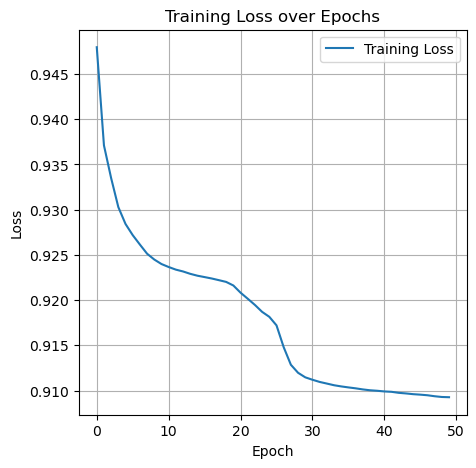

[[ 0.          0.94795009  0.57602885  0.55388591  0.45920476  0.32240484]
 [ 5.          0.9271814   0.61701182  0.58562128  0.56808001  0.42815504]
 [10.          0.92365861  0.58196179  0.55810522  0.24714494  0.15454965]
 [15.          0.92254425  0.56360904  0.54035923  0.24419628  0.15582505]
 [20.          0.92082096  0.52944379  0.50747645  0.23612631  0.14962006]
 [25.          0.91721017  0.70882558  0.66502907  0.7581017   0.64132521]
 [30.          0.91119805  0.66998185  0.6251894   0.78471052  0.67392657]
 [35.          0.91035182  0.65529811  0.61149242  0.79017213  0.6825332 ]
 [40.          0.90990681  0.66503385  0.62035421  0.79974066  0.69385958]
 [45.          0.90955141  0.65147253  0.60716117  0.80577412  0.70214189]]


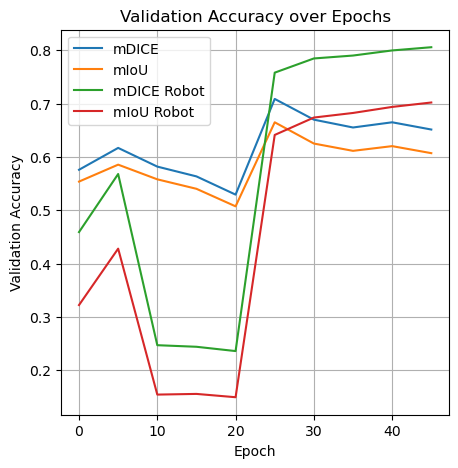

In [5]:
# process outputs 
training_outputs_cpu = []
for i in training_outputs:
    temp = []
    for j in i:
        if torch.is_tensor(j):
            temp.append(j.cpu())
        else:
            temp.append(j)
    training_outputs_cpu.append(temp)
    
training_outputs_cpu = np.array(training_outputs_cpu)

#print training loss
plt.figure(figsize=(5, 5))
plt.plot(training_outputs_cpu[:,0], training_outputs_cpu[:,1], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#print validation scores
training_outputs_cpu_filtered = [value for index, value in enumerate(training_outputs_cpu) if index % 5 == 0]
training_outputs_cpu_filtered = np.array(training_outputs_cpu_filtered)
print(training_outputs_cpu_filtered)
plt.figure(figsize=(5, 5))
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,2], label='mDICE')
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,3], label='mIoU')
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,4], label='mDICE Robot')
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,5], label='mIoU Robot')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [6]:
# test model
m_dice, m_iou, mdice_robot, miou_robot = TrainingUtils.test(model, test_dataloader, device)
print(f"Mean DICE Score: {m_dice}")
print(f"Mean IoU Score: {m_iou}")
print(f"Mean DICE Robot Score: {mdice_robot}")
print(f"Mean IoU Robot Score: {miou_robot}")

125it [17:15,  8.28s/it]

Mean DICE Score: 0.6911950654638687
Mean IoU Score: 0.6457420002945963
Mean DICE Robot Score: 0.7248713746944212
Mean IoU Robot Score: 0.6264567467287704


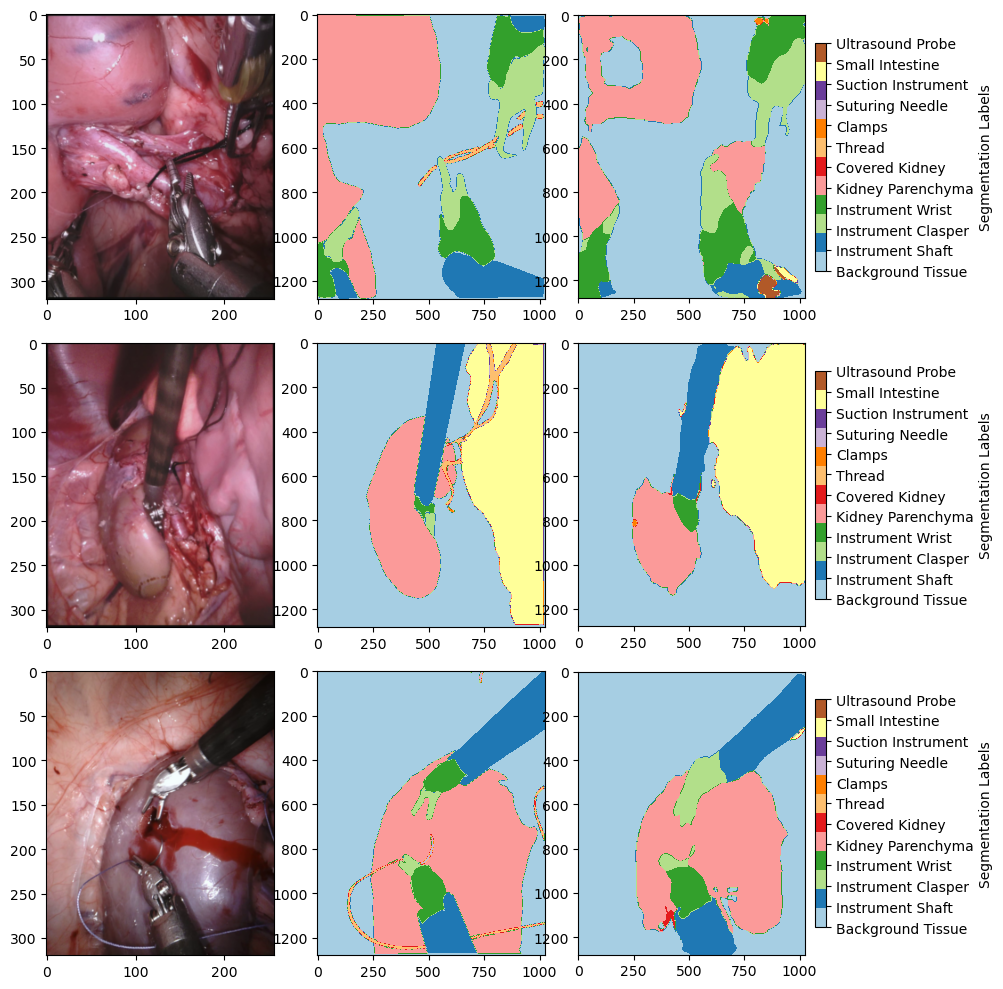

In [7]:
def get_ith_sample(dataloader, i):
    
    batch_size = dataloader.batch_size  
    batch_idx = i // batch_size         
    sample_idx = i % batch_size         

    for current_batch_idx, (images, labels) in enumerate(dataloader):
        if current_batch_idx == batch_idx:
            # Return the i-th sample from the batch
            return images[sample_idx], labels[sample_idx]

# display model outputs
model.cpu()
#i = 1 # 0 to batch_size
# pick 3 "random" images to compare models on
imgs, labels = [], []
img1, lab1 = get_ith_sample(val_dataloader, 198)
img2, lab2 = get_ith_sample(val_dataloader, 271)
img3, lab3 = get_ith_sample(test_dataloader, 159)
imgs = [img1, img2, img3]
labels = [lab1, lab2, lab3]
results = []

for i in range(3):
    input, label = imgs[i].unsqueeze(0), labels[i].unsqueeze(0)

    predict = model(input) # predict image
    predict = torch.argmax(predict, dim=1) # get grayscale prediction
    predict = torch.eye(12, device=predict.device)[predict].permute(0,3,1,2)
    predict = torch.nn.functional.interpolate(predict.float(), size=label.shape[2:], mode="nearest-exact")  # match label size
    prediction = EndovisDataloader.convert_masks_to_gray(predict.squeeze(0))

    label = EndovisDataloader.convert_masks_to_gray(label.squeeze(0))

    cmap = plt.get_cmap('Paired',12)
    cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
    cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
                "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

    # un-normalize input
    mean = torch.tensor([0.464, 0.341, 0.363]).view(-1, 1, 1)
    std = torch.tensor([0.210, 0.194, 0.204]).view(-1, 1, 1)
    input = input.squeeze(0) * std + mean

    results.append((input,label,prediction))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    axes[i,0].imshow(results[i][0].permute(1, 2, 0))
    axes[i,1].imshow(results[i][1], cmap = cmap, vmin = 0, vmax = 11)
    im = axes[i,2].imshow(results[i][2], cmap = cmap, vmin = 0, vmax = 11)

    cbar = fig.colorbar(im, ax=axes[i,2], fraction=0.046, pad=0.04)
    cbar.set_label("Segmentation Labels", fontsize=10)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)


plt.tight_layout()
plt.show()

# things to record: epochs, batch_size, reduce_factor, training loss curve, training time, validation score curves, test scores, test time, example image (below)